In [1]:
import datetime, os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.metrics import Accuracy
import tensorflow as tf


In [2]:
dftemp = pd.read_csv('/kaggle/input/paddy-disease-classification/train.csv')
dftemp.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


Text(0, 0.5, 'Count')

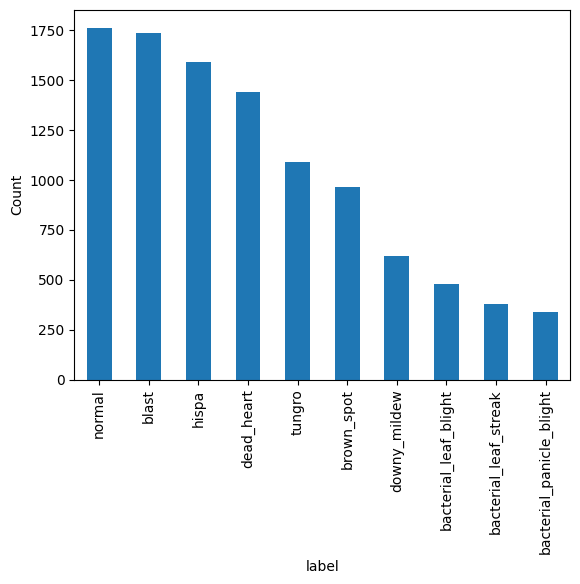

In [3]:
value_counts = dftemp['label'].value_counts().plot(kind = 'bar')
plt.ylabel("Count")

In [4]:
dftemp['variety'].value_counts()

variety
ADT45             6992
KarnatakaPonni     988
Ponni              657
AtchayaPonni       461
Zonal              399
AndraPonni         377
Onthanel           351
IR20               114
RR                  36
Surya               32
Name: count, dtype: int64

In [5]:
dftemp['age'].value_counts()

age
70    3077
60    1660
50    1066
75     866
65     774
55     563
72     552
45     505
67     415
68     253
80     225
57     213
47     112
77      42
73      38
66      36
62       5
82       5
Name: count, dtype: int64

In [6]:
train_ds.class_indices.keys()

NameError: name 'train_ds' is not defined

In [6]:
SEED = 548
BATCH_SIZE = 64
EPOCHS = 15
LEARNING_RATE = 0.13
IMAGE_SIZE = 112

img_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

In [7]:
train_ds = img_gen.flow_from_directory('../input/paddy-disease-classification/train_images',
                                       target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                       shuffle=True, 
                                       seed=SEED,
                                       class_mode='categorical',
                                       batch_size=BATCH_SIZE,
                                       subset="training")

classes = list(train_ds.class_indices.keys())

print('Classes: '+str(classes))

num_classes  = len(classes)

Found 9371 images belonging to 10 classes.
Classes: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


In [8]:
val_ds = img_gen.flow_from_directory('../input/paddy-disease-classification/train_images',
                                       target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                       shuffle=False, 
                                       seed=SEED,
                                       class_mode='categorical',
                                       batch_size=BATCH_SIZE,
                                       subset="validation")

Found 1036 images belonging to 10 classes.


In [9]:
test_ds = img_gen.flow_from_directory('../input/paddy-disease-classification/test_images',
                                      target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                      classes=['.'],
                                      class_mode= None,
                                      batch_size=BATCH_SIZE)

Found 3469 images belonging to 1 classes.


In [10]:
nb_train_samples = train_ds.samples

steps_per_epoch = nb_train_samples // BATCH_SIZE

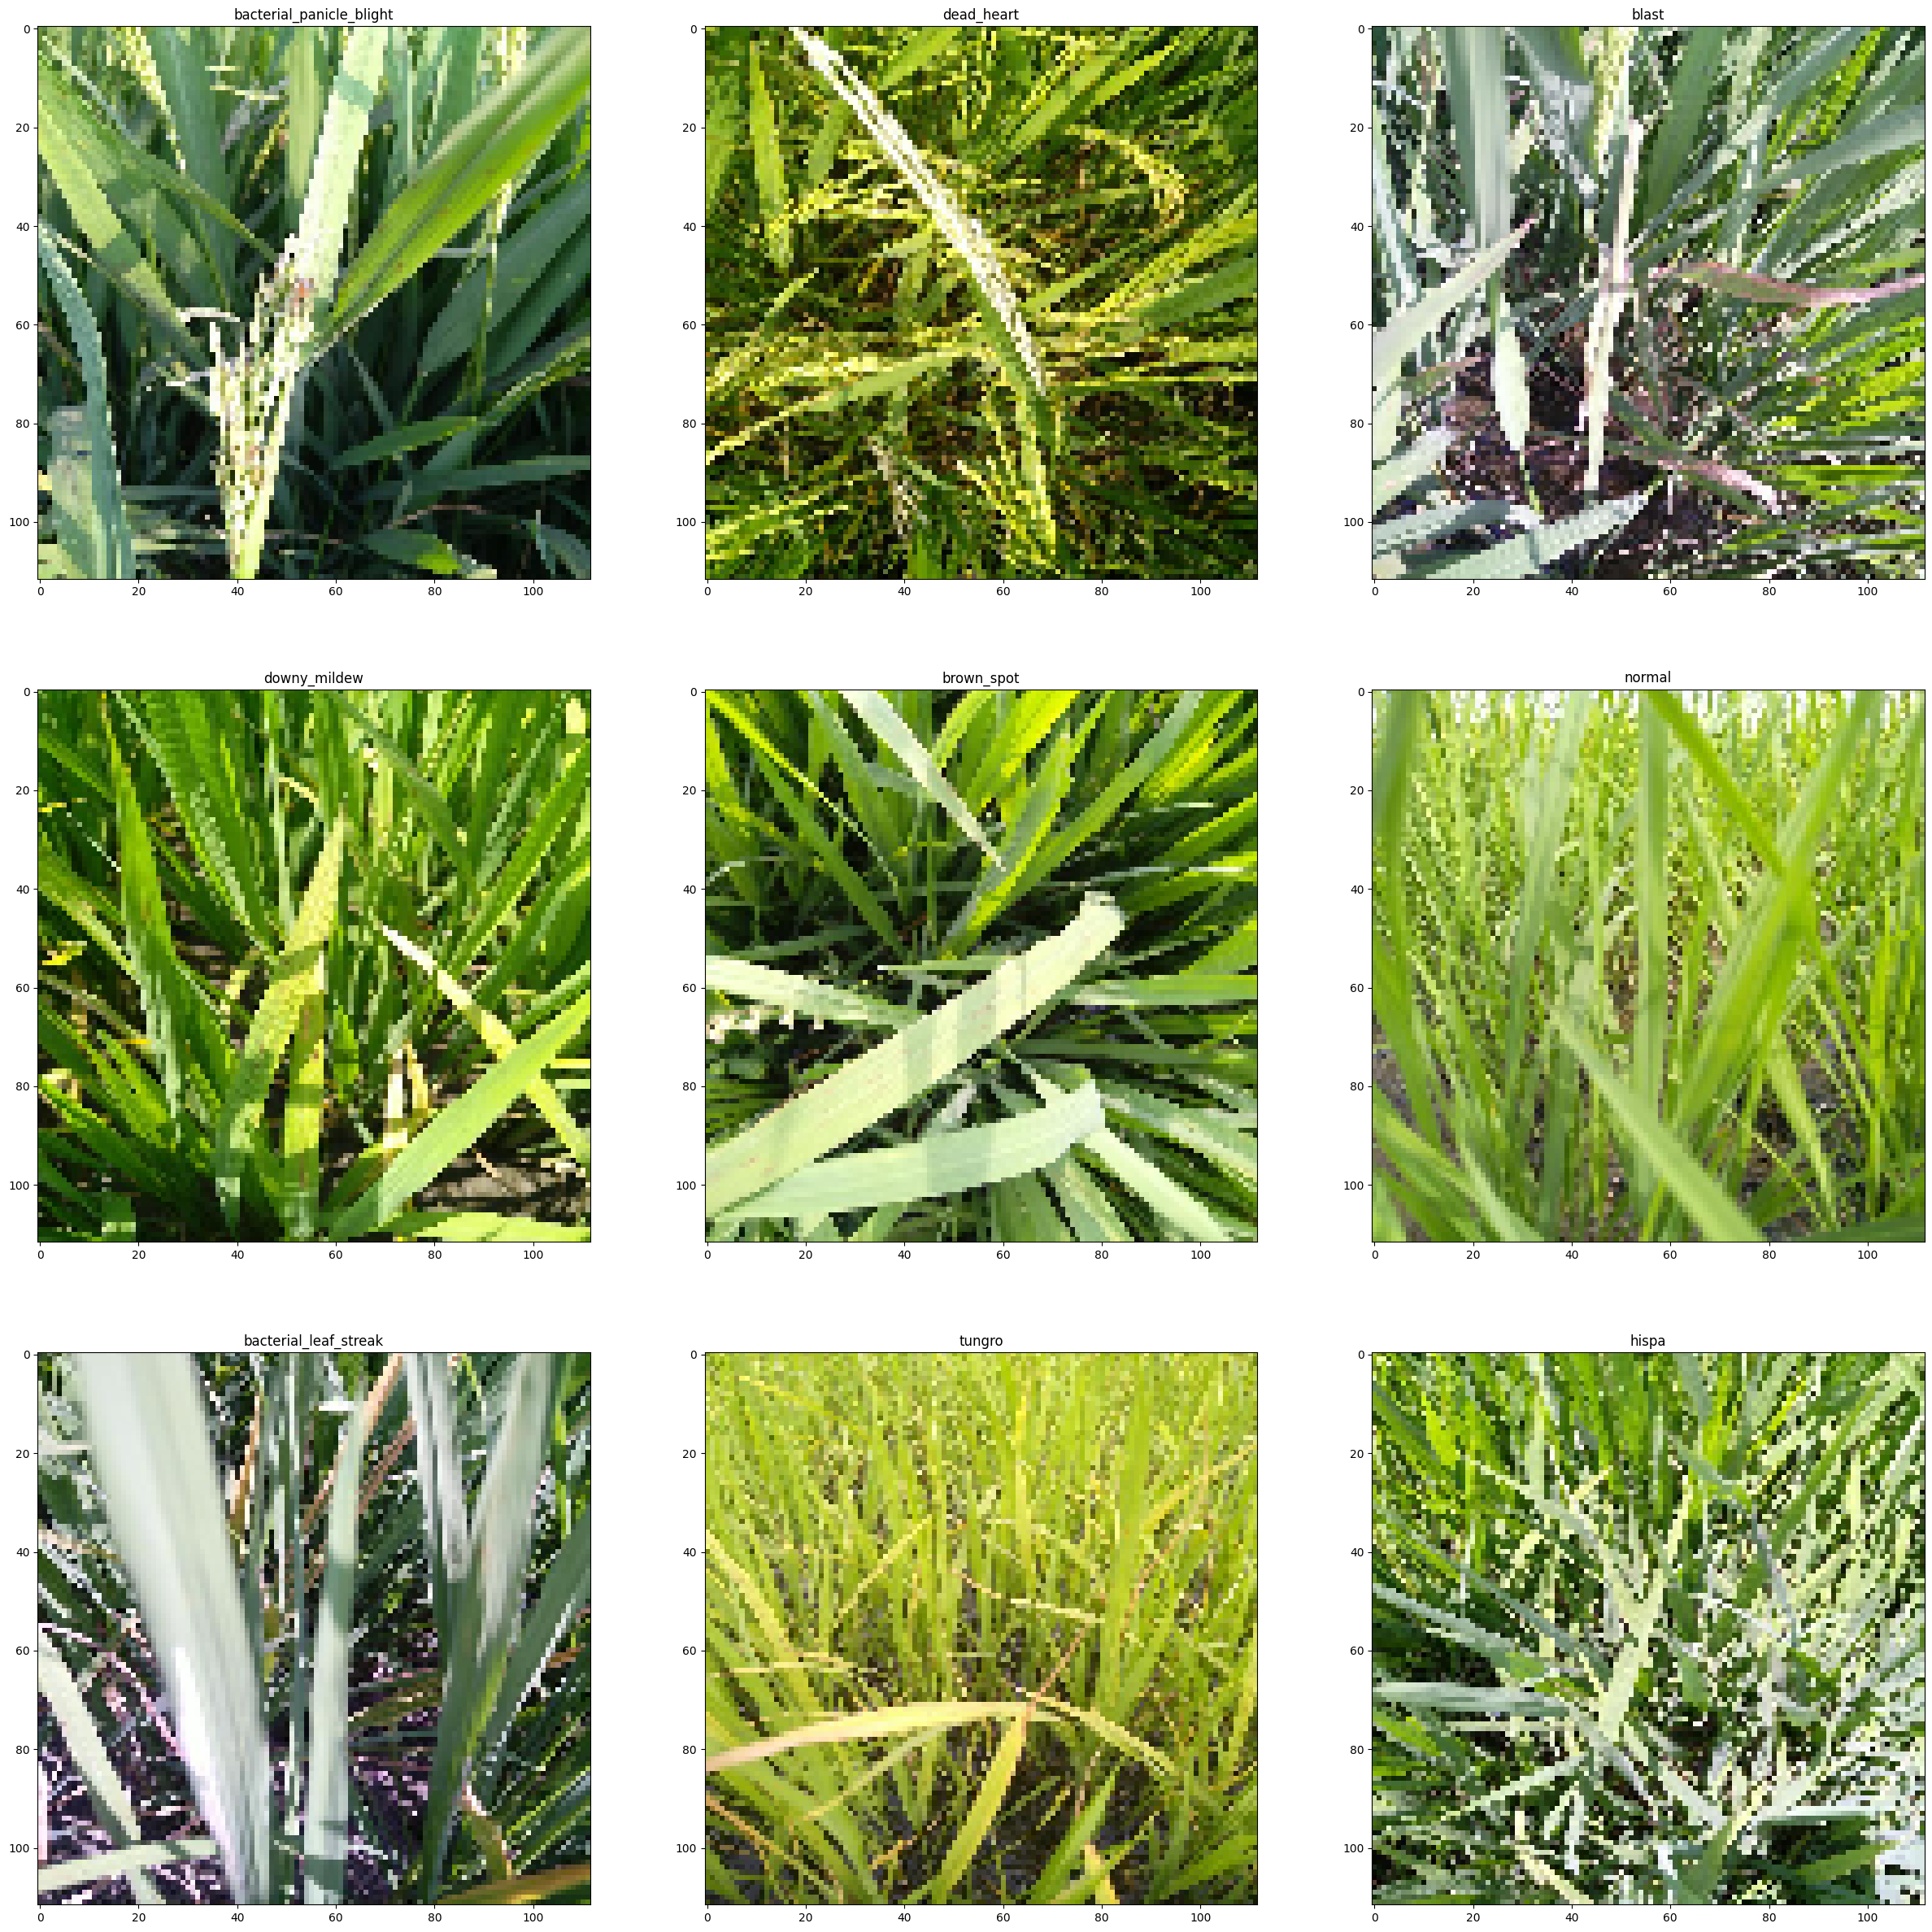

In [12]:
plt.figure(figsize=(30,30))
images = train_ds.next()*255
for i, (image, l) in enumerate(zip(images[0][:9],images[1][:9])):
    ax = plt.subplot(330 + 1 + i)
    ax.set_title( classes[np.argmax(l)] )
    plt.imshow(image)
plt.show()

# model 3

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(8192, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Adding dropout for regularization
    
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Adding dropout for regularization
    
    tf.keras.layers.Dense(128, activation='relu'),
    
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [22]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 110, 110, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 110, 110, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 55, 55, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 53, 53, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 53, 53, 32)       128       
 hNormalization)                                                 
                                                      

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define callback functions
checkpoint = ModelCheckpoint("model_2.h5", monitor="val_loss", save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss", patience=4)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=0.0001)

# Create a list of callbacks to be passed to the fit method
callbacks = [checkpoint, early_stopping, reduce_lr]

In [24]:
# history = model.fit(
#     train_ds,
#     steps_per_epoch = steps_per_epoch,
#     epochs = 15,
#     validation_data = val_ds
# )

history = model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/20
146/146 [==============================] - 132s 885ms/step - loss: 1.7322 - accuracy: 0.4162 - val_loss: 3.9753 - val_accuracy: 0.1535 - lr: 0.0010
Epoch 2/20
146/146 [==============================] - 129s 881ms/step - loss: 1.2163 - accuracy: 0.6003 - val_loss: 3.2164 - val_accuracy: 0.2577 - lr: 0.0010
Epoch 3/20
146/146 [==============================] - 127s 871ms/step - loss: 0.8581 - accuracy: 0.7238 - val_loss: 1.5143 - val_accuracy: 0.5270 - lr: 0.0010
Epoch 4/20
146/146 [==============================] - 128s 876ms/step - loss: 0.6398 - accuracy: 0.7993 - val_loss: 0.7366 - val_accuracy: 0.7558 - lr: 0.0010
Epoch 5/20
146/146 [==============================] - 128s 873ms/step - loss: 0.4691 - accuracy: 0.8589 - val_loss: 0.8599 - val_accuracy: 0.7346 - lr: 0.0010
Epoch 6/20
146/146 [==============================] - 128s 873ms/step - loss: 0.3639 - accuracy: 0.8863 - val_loss: 1.5879 - val_accuracy: 0.5994 - lr: 0.0010
Epoch 7/20
146/146 [==========================

In [42]:
for i in history.history:
    print(history.history[i])

[1.7321587800979614, 1.2162948846817017, 0.8581289052963257, 0.6397836208343506, 0.46905598044395447, 0.36389052867889404, 0.29183632135391235, 0.25135138630867004, 0.1937801092863083, 0.1835940033197403, 0.17087367177009583, 0.12597228586673737, 0.05648311600089073, 0.022185081616044044, 0.015231799334287643, 0.010600288398563862, 0.007419145666062832]
[0.41624584794044495, 0.6003008484840393, 0.7237563133239746, 0.7992908358573914, 0.8589233756065369, 0.8863221406936646, 0.9104974865913391, 0.9252175688743591, 0.9424089193344116, 0.942946195602417, 0.9501450657844543, 0.9623938798904419, 0.9816267490386963, 0.9937681555747986, 0.9952723979949951, 0.9972063899040222, 0.9980659484863281]
[3.9753172397613525, 3.2163710594177246, 1.5143425464630127, 0.7365739941596985, 0.8599393963813782, 1.5879223346710205, 0.7251508235931396, 0.7450519800186157, 0.6532065272331238, 1.0788301229476929, 0.670475959777832, 0.6733139157295227, 0.41085582971572876, 0.4126605689525604, 0.4599948823451996, 0.

In [25]:
# Save the model in the SavedModel format
saved_model_path = "//kaggle//working//"
tf.saved_model.save(model, saved_model_path)

# Convert the SavedModel to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

# Save the TFLite model to a file
tflite_model_path = "my_model_3_6_11.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

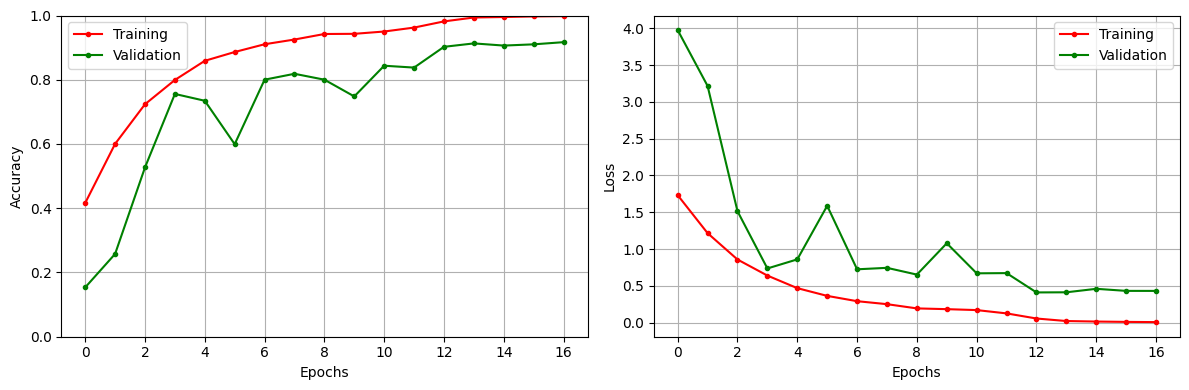

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(history.history["accuracy"], color="r",marker = '.')
ax1.plot(history.history["val_accuracy"], color="g",marker = '.')
ax1.legend(["Training", "Validation"])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.set_ylim(0, 1)

# Plot loss
ax2.plot(history.history["loss"], color="r",marker = '.')
ax2.plot(history.history["val_loss"], color="g",marker = '.')
ax2.legend(["Training", "Validation"])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.grid()

# Show the subplots
plt.tight_layout()
plt.show()

17/17 [==============================] - 6s 334ms/step
Precision: 0.9172
Recall: 0.9170
F1 Score: 0.9162
Accuracy: 0.9170


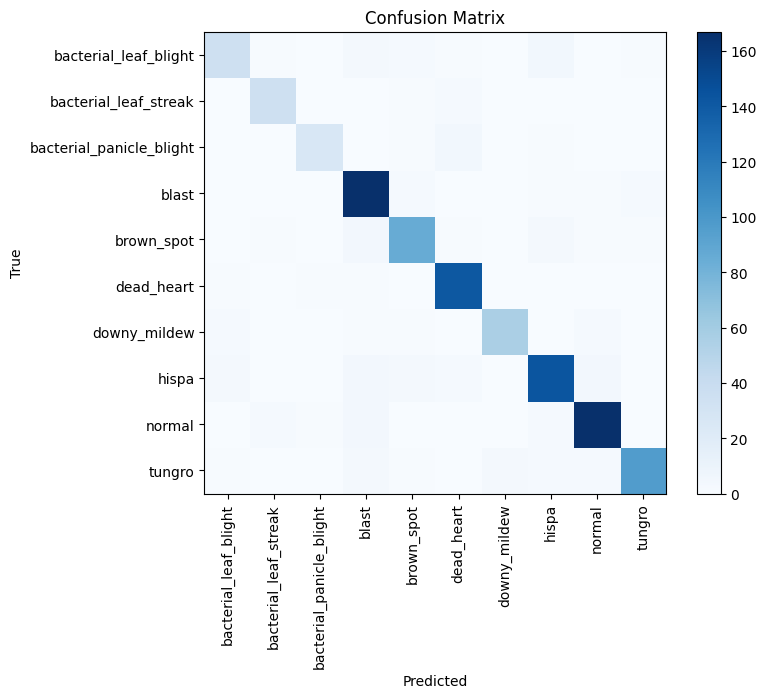

In [30]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the validation dataset
val_results = model.evaluate(val_ds)

# Predict labels for the validation dataset
val_pred_probs = model.predict(val_ds)
val_pred_labels = np.argmax(val_pred_probs, axis=1)

# Extract true labels from val_ds
val_true_labels = val_ds.classes

# Compute precision, recall, F1 score, and accuracy
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(val_true_labels, val_pred_labels, average='weighted')
recall = recall_score(val_true_labels, val_pred_labels, average='weighted')
f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')
accuracy = accuracy_score(val_true_labels, val_pred_labels)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

# Create a confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [35]:
# Classification Report
report = classification_report(val_true_labels, val_pred_labels, target_names=classes, output_dict=True)
print(report)

{'bacterial_leaf_blight': {'precision': 0.8292682926829268, 'recall': 0.723404255319149, 'f1-score': 0.7727272727272727, 'support': 47}, 'bacterial_leaf_streak': {'precision': 0.8974358974358975, 'recall': 0.9210526315789473, 'f1-score': 0.9090909090909091, 'support': 38}, 'bacterial_panicle_blight': {'precision': 0.9285714285714286, 'recall': 0.7878787878787878, 'f1-score': 0.8524590163934426, 'support': 33}, 'blast': {'precision': 0.893048128342246, 'recall': 0.9653179190751445, 'f1-score': 0.9277777777777777, 'support': 173}, 'brown_spot': {'precision': 0.8854166666666666, 'recall': 0.8854166666666666, 'f1-score': 0.8854166666666666, 'support': 96}, 'dead_heart': {'precision': 0.9276315789473685, 'recall': 0.9791666666666666, 'f1-score': 0.9527027027027027, 'support': 144}, 'downy_mildew': {'precision': 0.9491525423728814, 'recall': 0.9032258064516129, 'f1-score': 0.9256198347107438, 'support': 62}, 'hispa': {'precision': 0.910828025477707, 'recall': 0.89937106918239, 'f1-score': 0.

In [36]:
report_df = pd.DataFrame(report).transpose()

# Display the report DataFrame
print(report_df)

                          precision    recall  f1-score      support
bacterial_leaf_blight      0.829268  0.723404  0.772727    47.000000
bacterial_leaf_streak      0.897436  0.921053  0.909091    38.000000
bacterial_panicle_blight   0.928571  0.787879  0.852459    33.000000
blast                      0.893048  0.965318  0.927778   173.000000
brown_spot                 0.885417  0.885417  0.885417    96.000000
dead_heart                 0.927632  0.979167  0.952703   144.000000
downy_mildew               0.949153  0.903226  0.925620    62.000000
hispa                      0.910828  0.899371  0.905063   159.000000
normal                     0.943503  0.948864  0.946176   176.000000
tungro                     0.960000  0.888889  0.923077   108.000000
accuracy                   0.916988  0.916988  0.916988     0.916988
macro avg                  0.912486  0.890259  0.900011  1036.000000
weighted avg               0.917184  0.916988  0.916218  1036.000000


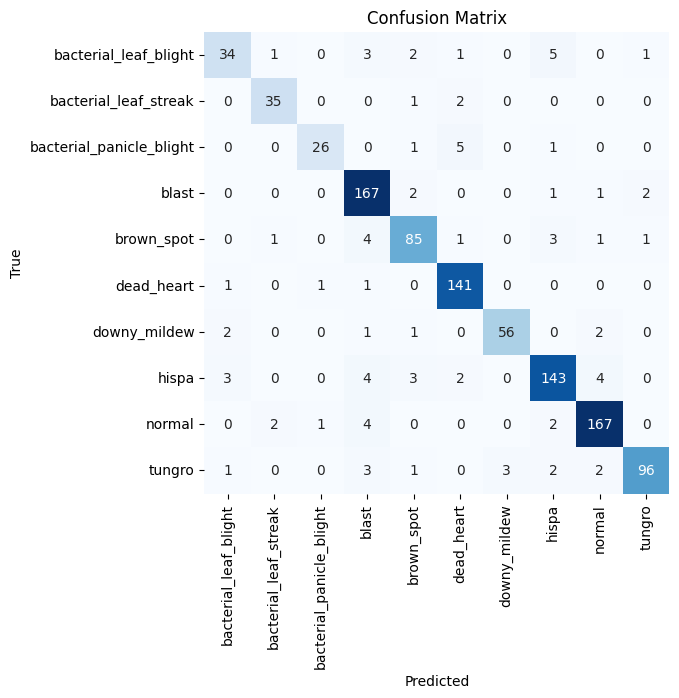

In [32]:
# Create a confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)
import seaborn as sns
# Visualize the confusion matrix with values and angled x-axis labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.show()

In [ ]:
pip install visualkeras

In [ ]:
import visualkeras
from visualkeras import layered_view
layered_model = layered_view(model, legend=True)
# Save the visualization to an image file
layered_model.save('model_visualization.png')

# Display the visualization (optional)
from IPython.display import Image
Image(filename='model_visualization.png')

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch = steps_per_epoch,
    epochs = 15,
    validation_data = val_ds
)

#model.summary()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(history.history["accuracy"], color="r")
ax1.plot(history.history["val_accuracy"], color="g")
ax1.legend(["Training", "Validation"])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.set_ylim(0, 1)

# Plot loss
ax2.plot(history.history["loss"], color="r")
ax2.plot(history.history["val_loss"], color="g")
ax2.legend(["Training", "Validation"])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.grid()

# Show the subplots
plt.tight_layout()
plt.show()

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the validation dataset
val_results = model.evaluate(val_ds)

# Predict labels for the validation dataset
val_pred_probs = model.predict(val_ds)
val_pred_labels = np.argmax(val_pred_probs, axis=1)

# Extract true labels from val_ds
val_true_labels = val_ds.classes

# Compute precision, recall, F1 score, and accuracy
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(val_true_labels, val_pred_labels, average='weighted')
recall = recall_score(val_true_labels, val_pred_labels, average='weighted')
f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')
accuracy = accuracy_score(val_true_labels, val_pred_labels)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

# Create a confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)
import seaborn as sns
# Visualize the confusion matrix with values and angled x-axis labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.show()

# model 2

In [11]:



# Create the model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8192, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Add dropout to reduce overfitting
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Add dropout to reduce overfitting
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0

In [13]:

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define callback functions
checkpoint = ModelCheckpoint("model_2.h5", monitor="val_loss", save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss", patience=4)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=0.0001)

# Create a list of callbacks to be passed to the fit method
callbacks = [checkpoint, early_stopping, reduce_lr]
history = model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/20
146/146 [==============================] - 145s 969ms/step - loss: 2.0611 - accuracy: 0.2436 - val_loss: 1.9604 - val_accuracy: 0.2915 - lr: 0.0010
Epoch 2/20
146/146 [==============================] - 106s 727ms/step - loss: 1.7622 - accuracy: 0.3770 - val_loss: 1.5869 - val_accuracy: 0.4073 - lr: 0.0010
Epoch 3/20
146/146 [==============================] - 107s 729ms/step - loss: 1.6178 - accuracy: 0.4375 - val_loss: 1.4941 - val_accuracy: 0.4884 - lr: 0.0010
Epoch 4/20
146/146 [==============================] - 107s 733ms/step - loss: 1.4159 - accuracy: 0.5046 - val_loss: 1.2893 - val_accuracy: 0.5483 - lr: 0.0010
Epoch 5/20
146/146 [==============================] - 109s 744ms/step - loss: 1.2142 - accuracy: 0.5831 - val_loss: 1.2356 - val_accuracy: 0.5859 - lr: 0.0010
Epoch 6/20
146/146 [==============================] - 108s 738ms/step - loss: 1.0247 - accuracy: 0.6387 - val_loss: 1.0120 - val_accuracy: 0.6544 - lr: 0.0010
Epoch 7/20
146/146 [==========================

In [16]:
# Save the model in the SavedModel format
saved_model_path = "//kaggle//working//"
tf.saved_model.save(model, saved_model_path)

# Convert the SavedModel to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

# Save the TFLite model to a file
tflite_model_path = "my_model_2_6_11.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

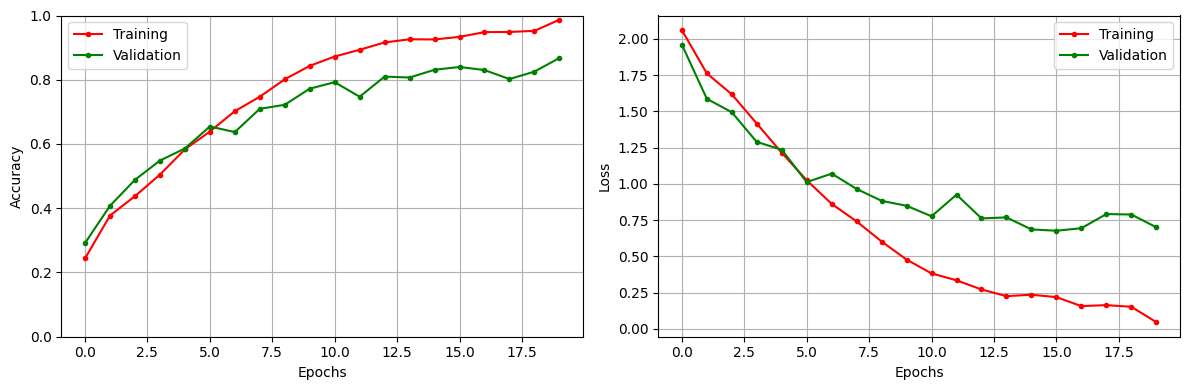

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(history.history["accuracy"], color="r",marker = '.')
ax1.plot(history.history["val_accuracy"], color="g",marker = '.')
ax1.legend(["Training", "Validation"])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.set_ylim(0, 1)

# Plot loss
ax2.plot(history.history["loss"], color="r",marker = '.')
ax2.plot(history.history["val_loss"], color="g",marker = '.')
ax2.legend(["Training", "Validation"])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.grid()

# Show the subplots
plt.tight_layout()
plt.show()

17/17 [==============================] - 6s 325ms/step
Precision: 0.8680
Recall: 0.8678
F1 Score: 0.8674
Accuracy: 0.8678


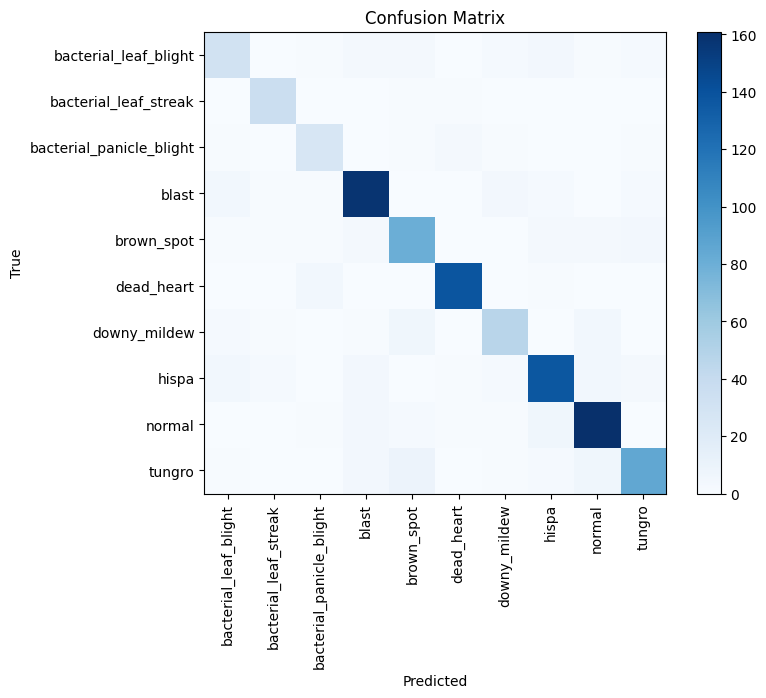

In [16]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the validation dataset
val_results = model.evaluate(val_ds)

# Predict labels for the validation dataset
val_pred_probs = model.predict(val_ds)
val_pred_labels = np.argmax(val_pred_probs, axis=1)

# Extract true labels from val_ds
val_true_labels = val_ds.classes

# Compute precision, recall, F1 score, and accuracy
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(val_true_labels, val_pred_labels, average='weighted')
recall = recall_score(val_true_labels, val_pred_labels, average='weighted')
f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')
accuracy = accuracy_score(val_true_labels, val_pred_labels)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

# Create a confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


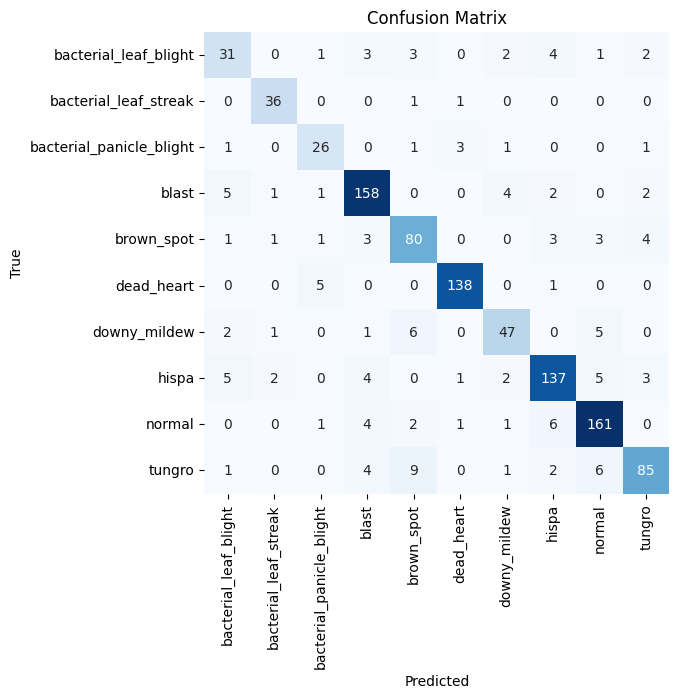

In [17]:
# Create a confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)
import seaborn as sns
# Visualize the confusion matrix with values and angled x-axis labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.show()

In [18]:
for i in history.history:
    print(history.history[i])

[2.0610556602478027, 1.7621567249298096, 1.617838740348816, 1.4158923625946045, 1.2141504287719727, 1.0247188806533813, 0.8617477416992188, 0.7406432628631592, 0.6020175218582153, 0.47715240716934204, 0.38197407126426697, 0.3344130218029022, 0.27097877860069275, 0.2252032458782196, 0.23487628996372223, 0.2182210087776184, 0.15627089142799377, 0.16314440965652466, 0.1515599638223648, 0.04581855610013008]
[0.24358010292053223, 0.37702804803848267, 0.4375201463699341, 0.5045664310455322, 0.5831094980239868, 0.6386590600013733, 0.7022671103477478, 0.7470721006393433, 0.8014397621154785, 0.8431288003921509, 0.8723541498184204, 0.8933061361312866, 0.9160846471786499, 0.9259697198867798, 0.9254324436187744, 0.9334909319877625, 0.9482110142707825, 0.9487482309341431, 0.9521617889404297, 0.9868915677070618]
[1.9604156017303467, 1.5869032144546509, 1.4941037893295288, 1.289253830909729, 1.2356258630752563, 1.0119653940200806, 1.070592999458313, 0.964749276638031, 0.8827409148216248, 0.8486495018

In [19]:
# Classification Report
report = classification_report(val_true_labels, val_pred_labels, target_names=classes, output_dict=True)
print(report)
report_df = pd.DataFrame(report).transpose()

# Display the report DataFrame
print(report_df)

{'bacterial_leaf_blight': {'precision': 0.6739130434782609, 'recall': 0.6595744680851063, 'f1-score': 0.6666666666666667, 'support': 47}, 'bacterial_leaf_streak': {'precision': 0.8780487804878049, 'recall': 0.9473684210526315, 'f1-score': 0.9113924050632912, 'support': 38}, 'bacterial_panicle_blight': {'precision': 0.7428571428571429, 'recall': 0.7878787878787878, 'f1-score': 0.7647058823529412, 'support': 33}, 'blast': {'precision': 0.8926553672316384, 'recall': 0.9132947976878613, 'f1-score': 0.9028571428571429, 'support': 173}, 'brown_spot': {'precision': 0.7843137254901961, 'recall': 0.8333333333333334, 'f1-score': 0.8080808080808081, 'support': 96}, 'dead_heart': {'precision': 0.9583333333333334, 'recall': 0.9583333333333334, 'f1-score': 0.9583333333333334, 'support': 144}, 'downy_mildew': {'precision': 0.8103448275862069, 'recall': 0.7580645161290323, 'f1-score': 0.7833333333333333, 'support': 62}, 'hispa': {'precision': 0.8838709677419355, 'recall': 0.8616352201257862, 'f1-score

In [ ]:
import visualkeras
from visualkeras import layered_view
layered_model = layered_view(model, legend=True)
# Save the visualization to an image file
layered_model.save('model_visualization2.png')

# Display the visualization (optional)
from IPython.display import Image
Image(filename='model_visualization2.png')

In [ ]:
# Data augmentation
img_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

In [ ]:
print(IMAGE_SIZE)

# model 1

In [20]:

model = tf.keras.Sequential([
tf.keras.layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2, 2),
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(8192, activation='relu'),
tf.keras.layers.Dense(1024, activation='relu'),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 110, 110, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 55, 55, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 53, 53, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 12, 12, 64)      

In [21]:

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define callback functions
checkpoint = ModelCheckpoint("model_2.h5", monitor="val_loss", save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss", patience=4)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=0.0001)

# Create a list of callbacks to be passed to the fit method
callbacks = [checkpoint, early_stopping, reduce_lr]
history = model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/20
146/146 [==============================] - 108s 727ms/step - loss: 2.1384 - accuracy: 0.1960 - val_loss: 2.0362 - val_accuracy: 0.2432 - lr: 0.0010
Epoch 2/20
146/146 [==============================] - 105s 716ms/step - loss: 1.8126 - accuracy: 0.3549 - val_loss: 1.6564 - val_accuracy: 0.4324 - lr: 0.0010
Epoch 3/20
146/146 [==============================] - 105s 718ms/step - loss: 1.6202 - accuracy: 0.4306 - val_loss: 1.5364 - val_accuracy: 0.4633 - lr: 0.0010
Epoch 4/20
146/146 [==============================] - 104s 712ms/step - loss: 1.4383 - accuracy: 0.5019 - val_loss: 1.4683 - val_accuracy: 0.5386 - lr: 0.0010
Epoch 5/20
146/146 [==============================] - 105s 717ms/step - loss: 1.2664 - accuracy: 0.5593 - val_loss: 1.3236 - val_accuracy: 0.5270 - lr: 0.0010
Epoch 6/20
146/146 [==============================] - 105s 719ms/step - loss: 1.1153 - accuracy: 0.6181 - val_loss: 1.0972 - val_accuracy: 0.6351 - lr: 0.0010
Epoch 7/20
146/146 [==========================

In [22]:
# Save the model in the SavedModel format
saved_model_path = "//kaggle//working//"
tf.saved_model.save(model, saved_model_path)

# Convert the SavedModel to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

# Save the TFLite model to a file
tflite_model_path = "my_model_1_6_11.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

In [ ]:
# # Training the model
# history = model.fit(
#     train_ds,
#     steps_per_epoch=steps_per_epoch,
#     epochs=EPOCHS,
#     validation_data=val_ds,
#     callbacks=[early_stopping, lr_schedule],
# )


In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping_callback]
)


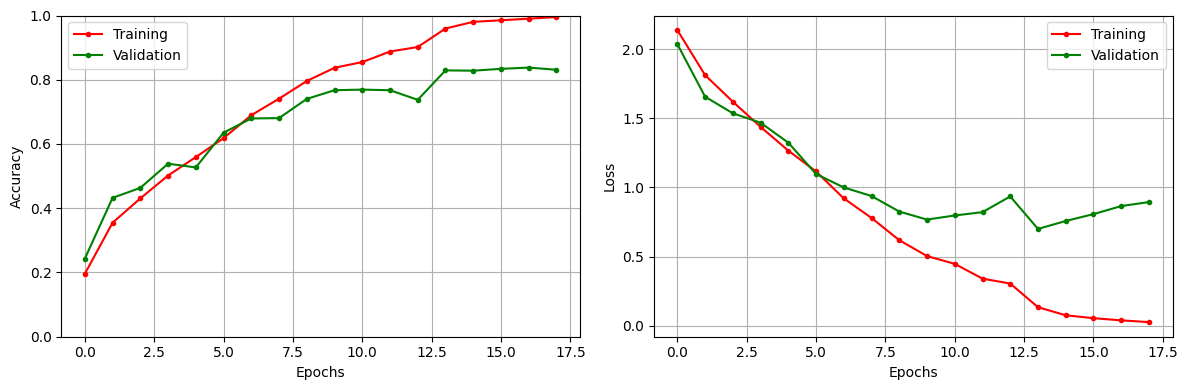

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(history.history["accuracy"], color="r",marker = '.')
ax1.plot(history.history["val_accuracy"], color="g",marker = '.')
ax1.legend(["Training", "Validation"])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.set_ylim(0, 1)

# Plot loss
ax2.plot(history.history["loss"], color="r",marker = '.')
ax2.plot(history.history["val_loss"], color="g",marker = '.')
ax2.legend(["Training", "Validation"])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.grid()

# Show the subplots
plt.tight_layout()
plt.show()

In [26]:
for i in history.history:
    print(history.history[i])

[2.1384494304656982, 1.812583327293396, 1.6202106475830078, 1.4382576942443848, 1.2663873434066772, 1.1152558326721191, 0.9205104112625122, 0.7789678573608398, 0.6180989742279053, 0.5033169388771057, 0.4469395577907562, 0.34000787138938904, 0.30432626605033875, 0.1334356963634491, 0.07481682300567627, 0.053763821721076965, 0.038119807839393616, 0.025287805125117302]
[0.19598151743412018, 0.35489416122436523, 0.43064358830451965, 0.5018802881240845, 0.5592564940452576, 0.6181368827819824, 0.6896404027938843, 0.7409476637840271, 0.795960009098053, 0.8373267650604248, 0.8549478650093079, 0.887718915939331, 0.9019017815589905, 0.9593853950500488, 0.980337381362915, 0.9850649833679199, 0.9902223944664001, 0.9950574636459351]
[2.036170482635498, 1.6563624143600464, 1.5364230871200562, 1.46829354763031, 1.3236206769943237, 1.0972270965576172, 0.9996657371520996, 0.937710165977478, 0.8252736926078796, 0.7674221396446228, 0.7969266772270203, 0.8211385607719421, 0.9346955418586731, 0.69974321126

17/17 [==============================] - 6s 320ms/step
Precision: 0.8337
Recall: 0.8311
F1 Score: 0.8313
Accuracy: 0.8311


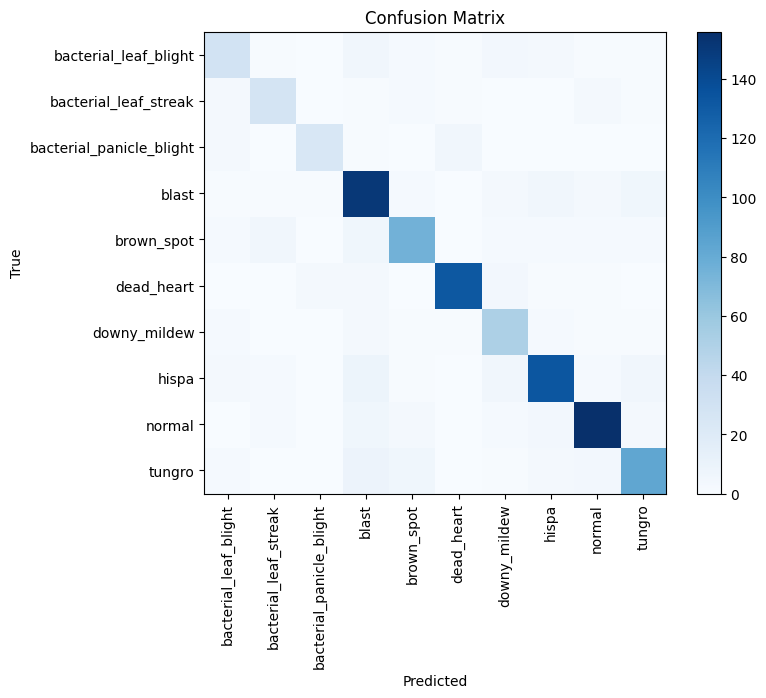

In [24]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the validation dataset
val_results = model.evaluate(val_ds)

# Predict labels for the validation dataset
val_pred_probs = model.predict(val_ds)
val_pred_labels = np.argmax(val_pred_probs, axis=1)

# Extract true labels from val_ds
val_true_labels = val_ds.classes

# Compute precision, recall, F1 score, and accuracy
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(val_true_labels, val_pred_labels, average='weighted')
recall = recall_score(val_true_labels, val_pred_labels, average='weighted')
f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')
accuracy = accuracy_score(val_true_labels, val_pred_labels)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

# Create a confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


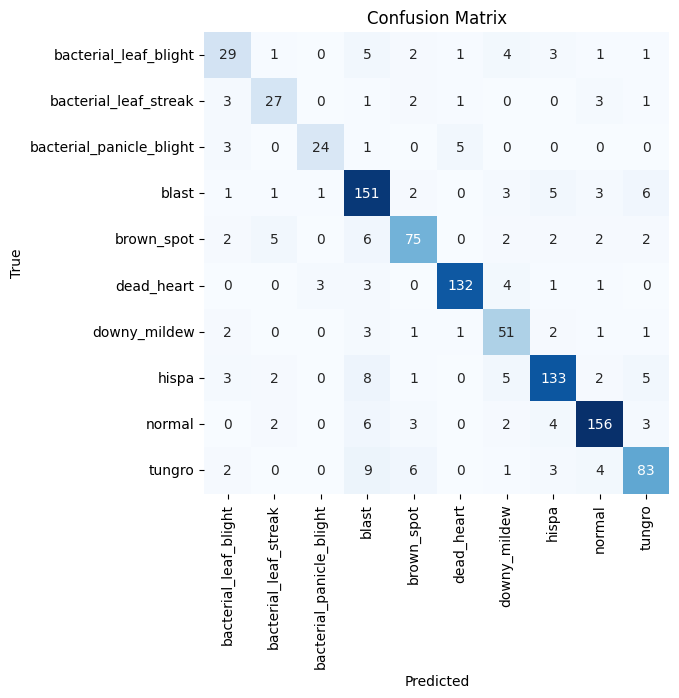

In [25]:
# Create a confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)
import seaborn as sns
# Visualize the confusion matrix with values and angled x-axis labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.show()

In [28]:
# Classification Report
report = classification_report(val_true_labels, val_pred_labels, target_names=classes, output_dict=True)
print(report)
report_df = pd.DataFrame(report).transpose()

# Display the report DataFrame
print(report_df)

{'bacterial_leaf_blight': {'precision': 0.6444444444444445, 'recall': 0.6170212765957447, 'f1-score': 0.6304347826086957, 'support': 47}, 'bacterial_leaf_streak': {'precision': 0.7105263157894737, 'recall': 0.7105263157894737, 'f1-score': 0.7105263157894737, 'support': 38}, 'bacterial_panicle_blight': {'precision': 0.8571428571428571, 'recall': 0.7272727272727273, 'f1-score': 0.7868852459016394, 'support': 33}, 'blast': {'precision': 0.7823834196891192, 'recall': 0.8728323699421965, 'f1-score': 0.825136612021858, 'support': 173}, 'brown_spot': {'precision': 0.8152173913043478, 'recall': 0.78125, 'f1-score': 0.797872340425532, 'support': 96}, 'dead_heart': {'precision': 0.9428571428571428, 'recall': 0.9166666666666666, 'f1-score': 0.9295774647887323, 'support': 144}, 'downy_mildew': {'precision': 0.7083333333333334, 'recall': 0.8225806451612904, 'f1-score': 0.7611940298507464, 'support': 62}, 'hispa': {'precision': 0.869281045751634, 'recall': 0.8364779874213837, 'f1-score': 0.852564102